In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors



In [2]:
file_path = "/gluster/data/dune/niclane/nlane_prod_strange_resample_fhc_run2_fhc_reco2_reco2_trainingimage_background_lambdamuon_ana.root"  
#file_path = "/gluster/data/dune/niclane/test.root"

root_file = uproot.open(file_path)
print(root_file.keys())

['imageanalyser;1', 'imageanalyser/SampleTree;1', 'imageanalyser/ImageTree;1', 'FRH;1', 'FRV;1', 'rICKR;1', 'rICKI;1', 'PreC;1', 'PostC;1', 'PostO;1', 'PreD;1', 'PostDO;1', 'ER;1']


In [3]:
tree_name = "imageanalyser/ImageTree" 
tree = root_file[tree_name]

print(tree.keys())

['run', 'subrun', 'event', 'event_type', 'planes', 'width', 'height', 'input_data', 'truth_data']


In [4]:
input_data = tree["input_data"].array(library="np")
truth_data = tree["truth_data"].array(library="np")

print("Shape:", input_data[1])
print("Data Type:", type(input_data))

Shape: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], ...]
Data Type: <class 'numpy.ndarray'>


In [5]:
print(f"Number of events: {len(input_data)}")  
print(f"Planes per event: {len(input_data[0])}")  
print(f"Pixels per plane: {len(input_data[0][0])}")

Number of events: 706
Planes per event: 3
Pixels per plane: 262144


In [6]:
event_index = 2
event = input_data[event_index]  
truth_event = truth_data[event_index] 

run_numbers = tree["run"].array(library="np")
subrun_numbers = tree["subrun"].array(library="np")
event_numbers = tree["event"].array(library="np")

event_type = tree["event_type"].array(library="np")

print(event_type[event_index])

print(type(input_data))
plane = event[0]
print(type(plane))

num_entries = tree.num_entries
print(f"Number of entries in {tree_name}: {num_entries}")

1
<class 'numpy.ndarray'>
<class 'uproot.containers.STLVector'>
Number of entries in imageanalyser/ImageTree: 706


In [7]:
W, H = 512, 512  

plane_images = [np.array(list(plane), dtype=np.float32).reshape(H, W) for plane in event]
truth_images = [np.array(list(plane), dtype=np.float32).reshape(H, W) for plane in truth_event]

plane_labels = ["U", "V", "W"]

r, sr, evnum = run_numbers[event_index], subrun_numbers[event_index], event_numbers[event_index]

for i, (input_img, truth_img) in enumerate(zip(plane_images, truth_images)):
    fig, ax = plt.subplots(figsize=(12, 12), dpi=600)

    ax.imshow(input_img,
              origin="lower",
              cmap="jet",
              norm=colors.PowerNorm(gamma=0.35, vmin=input_img.min(), vmax=input_img.max()))

    overlay = False
    if overlay:
        ax.imshow(truth_img, origin="lower", cmap="cool", alpha=0.4)

    ax.set_xticks([0, W - 1])
    ax.set_yticks([0, H - 1])
    ax.tick_params(axis="both", direction="out", length=6, width=1.5, labelsize=18)
    ax.set_xlim(0, W - 1)
    ax.set_ylim(0, H - 1)
    ax.set_xlabel("Local Wire Coord", fontsize=20)
    ax.set_ylabel("Local Drift Time", fontsize=20)
    ax.set_title(f"Plane {plane_labels[i]} (Run {r}, Subrun {sr}, Event {evnum})", fontsize=22)

    plt.tight_layout()
    plt.savefig(f"event_{r}_{sr}_{evnum}_plane_{plane_labels[i]}.png")
    plt.close(fig)

In [8]:
event_indices = [5]

run_numbers = tree["run"].array(library="np")
subrun_numbers = tree["subrun"].array(library="np")
event_numbers = tree["event"].array(library="np")
event_type = tree["event_type"].array(library="np")

W, H = 512, 512  
plane_labels = ["U", "V", "W"]

for event_index in event_indices:
    event = input_data[event_index]  
    truth_event = truth_data[event_index]  

    print(f"Processing Event Index: {event_index}")
    print(f"Event Type: {event_type[event_index]}")

    r, sr, evnum = run_numbers[event_index], subrun_numbers[event_index], event_numbers[event_index]

    plane_images = [np.array(list(plane), dtype=np.float32).reshape(H, W) for plane in event]
    truth_images = [np.array(list(plane), dtype=np.float32).reshape(H, W) for plane in truth_event]

    print(f"Number of truth image channels: {len(truth_images)}")

    for i, (input_img, truth_img) in enumerate(zip(plane_images, truth_images)):
        fig, ax = plt.subplots(figsize=(12, 12), dpi=600)

        ax.imshow(input_img,
                  origin="lower",
                  cmap="jet",
                  norm=colors.PowerNorm(gamma=0.35, vmin=input_img.min(), vmax=input_img.max()))

        overlay = True
        if overlay:
            ax.imshow(truth_img, origin="lower", cmap="cool", alpha=0.4)

        ax.set_xticks([0, W - 1])
        ax.set_yticks([0, H - 1])
        ax.tick_params(axis="both", direction="out", length=6, width=1.5, labelsize=18)
        ax.set_xlim(0, W - 1)
        ax.set_ylim(0, H - 1)
        ax.set_xlabel("Local Wire Coord", fontsize=20)
        ax.set_ylabel("Local Drift Time", fontsize=20)
        ax.set_title(f"Plane {plane_labels[i]} (Run {r}, Subrun {sr}, Event {evnum})", fontsize=22)

        plt.tight_layout()
        plt.savefig(f"event_{r}_{sr}_{evnum}_plane_{plane_labels[i]}.png")
        plt.close(fig)

Processing Event Index: 5
Event Type: 1
Number of truth image channels: 3


In [9]:
%load_ext autoreload
%autoreload 2
import yaml
import os
import torch
import numpy as np
import uproot
import matplotlib.pyplot as plt

from src.config import Config
from src.dataset import SegmentationDataset, ContrastiveDataset  
from src.visualiser import Visualiser
from src.trainers import SegmentationTrainer, ContrastiveTrainer

In [10]:
path = "cfg/default.yaml"
config = Config(path)

print("Loaded configuration:")
print(config.as_dict())
print("Dataset File Path:", config.get("dataset.file_path")) 

Loaded configuration:
{'train': {'objective': 'classification', 'num_epochs': 20, 'batch_size': 8, 'lr': 0.001, 'ckpt_dir': './checkpoints', 'temp': 0.1}, 'model': {'arch': 'UResNetEncoder', 'in_channels': 3, 'num_classes': 6, 'seg_classes': 2, 'filters': 32, 'dropout': 0.1, 'feat_dim': 128, 'optimizer': 'Adam', 'weight_decay': 0.0001}, 'dataset': {'path': '/gluster/data/dune/niclane/nlane_prod_strange_resample_fhc_run2_fhc_reco2_reco2_trainingimage_background_lambdamuon_ana.root', 'tree': 'imageanalyser/ImageTree', 'dims': {'width': 512, 'height': 512}, 'planes': ['U', 'V', 'W'], 'ind_plane_idx': 2, 'filters': {'event_type': 'all'}}}
Dataset File Path: None


In [11]:
try:
    segmentation_dataset = SegmentationDataset(config)
    print(f"SegmentationDataset initialized with {len(segmentation_dataset)} samples.")
except Exception as e:
    print(f"Error loading SegmentationDataset: {e}")

try:
    contrastive_dataset = ContrastiveDataset(config)
    print(f"ContrastiveDataset initialized with {len(contrastive_dataset)} samples.")
except Exception as e:
    print(f"Error loading ContrastiveDataset: {e}")

SegmentationDataset initialized with 706 samples.
ContrastiveDataset initialized with 706 samples.


In [12]:
visualiser = Visualiser(segmentation_dataset, width=512, height=512)

In [13]:
visualiser.visualise_event_planes(idx=10, save=True, show=False)

Rendering Event 10 | Plane U | Run 6369, Subrun 37, Event 1853
Rendering Event 10 | Plane V | Run 6369, Subrun 37, Event 1853
Rendering Event 10 | Plane W | Run 6369, Subrun 37, Event 1853


In [14]:
import yaml
from src.config import Config

config_path = "cfg/default.yaml"  
config = Config(config_path)

print("Training Config:\n", yaml.dump(config.as_dict(), default_flow_style=False))

Training Config:
 dataset:
  dims:
    height: 512
    width: 512
  filters:
    event_type: all
  ind_plane_idx: 2
  path: /gluster/data/dune/niclane/nlane_prod_strange_resample_fhc_run2_fhc_reco2_reco2_trainingimage_background_lambdamuon_ana.root
  planes:
  - U
  - V
  - W
  tree: imageanalyser/ImageTree
model:
  arch: UResNetEncoder
  dropout: 0.1
  feat_dim: 128
  filters: 32
  in_channels: 3
  num_classes: 6
  optimizer: Adam
  seg_classes: 2
  weight_decay: 0.0001
train:
  batch_size: 8
  ckpt_dir: ./checkpoints
  lr: 0.001
  num_epochs: 20
  objective: classification
  temp: 0.1



In [15]:
dataset = SegmentationDataset(config)
trainer = SegmentationTrainer(config, dataset)
#print(trainer.model)

/gluster/home/niclane/scanningforstrangeness/src/trainers.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32)


In [16]:
trainer.train()


**** Epoch 1 Training
 Batch 000 | Images: torch.Size([8, 3, 512, 512]) | Labels: torch.Size([8, 6, 512, 512])
 Batch 000 | Outputs: torch.Size([8, 6, 512, 512])
 Batch 000 | Global Weights: [0.00099803 0.33281824 0.00099769 0.375521   0.00099849 0.28866652]
 Batch 000 | Loss: 0.8968
 Batch 001 | Images: torch.Size([8, 3, 512, 512]) | Labels: torch.Size([8, 6, 512, 512])
 Batch 001 | Outputs: torch.Size([8, 6, 512, 512])
 Batch 001 | Global Weights: [0.00080434 0.34593895 0.00080425 0.3628055  0.00080471 0.28884232]
 Batch 001 | Loss: 0.7837
 Batch 002 | Images: torch.Size([8, 3, 512, 512]) | Labels: torch.Size([8, 6, 512, 512])


KeyboardInterrupt: 

In [ ]:
def load_model_checkpoint(checkpoint_path, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UResNet(
        in_dim=config.get("model.in_channels"),
        n_classes=config.get("model.num_classes"),
        n_filters=config.get("model.filters"),
        drop_prob=config.get("model.dropout"),
        y_range=None
    )
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    return model

def run_inference(model, sample):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image, truth = sample
    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
    prediction = torch.argmax(output, dim=1).cpu().squeeze(0)
    return image, truth, prediction

def visualise_prediction(image, truth, prediction, plane, run, subrun, event):
    fig, ax = plt.subplots(figsize=(12,12), dpi=600)
    norm_img = mcolors.PowerNorm(gamma=0.35, vmin=image.min(), vmax=image.max())
    ax.imshow(image, origin="lower", cmap="jet", norm=norm_img)
    num_classes = int(np.max(prediction)) + 1
    cmap_seg = plt.get_cmap("tab10", num_classes)
    boundaries = np.arange(-0.5, num_classes+0.5, 1)
    norm_seg = mcolors.BoundaryNorm(boundaries, cmap_seg.N)
    ax.imshow(prediction, origin="lower", cmap=cmap_seg, norm=norm_seg, alpha=0.5)
    ax.set_xticks([0, image.shape[1]-1])
    ax.set_yticks([0, image.shape[0]-1])
    ax.tick_params(axis="both", direction="out", length=6, width=1.5, labelsize=18)
    ax.set_xlabel("Local Wire Coord", fontsize=20)
    ax.set_ylabel("Local Drift Time", fontsize=20)
    ax.set_title(f"Plane {plane} | Run {run}, Subrun {subrun}, Event {event}", fontsize=22)
    plt.tight_layout()
    plt.savefig(f"inference_plane_{plane}_run_{run}_subrun_{subrun}_event_{event}.png")
    plt.show()
    plt.close(fig)

def visualise_model_inference(model, dataset, event_idx):
    sample = dataset[event_idx]
    image, truth, prediction = run_inference(model, sample)
    run, subrun, event = "Unknown", "Unknown", event_idx
    planes = ["U", "V", "W"]
    for i, plane in enumerate(planes):
        visualise_prediction(image[i], truth[i], prediction[i], plane, run, subrun, event)

def plot_loss_curve(epoch_loss_history):
    epochs = np.array([e[0] for e in epoch_loss_history])
    train_loss = np.array([e[1] for e in epoch_loss_history])
    train_err = np.array([e[2] for e in epoch_loss_history])
    val_loss = np.array([e[3] for e in epoch_loss_history])
    val_err = np.array([e[4] for e in epoch_loss_history])
    plt.figure(figsize=(10,6))
    plt.errorbar(epochs, train_loss, yerr=train_err, fmt='-o', capsize=5, label='Train Loss', color='blue', markerfacecolor='white')
    plt.errorbar(epochs, val_loss, yerr=val_err, fmt='-o', capsize=5, label='Validation Loss', color='orange', markerfacecolor='white')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('loss_curve.png', dpi=300)
    plt.show()


In [ ]:
checkpoint_path = "checkpoints/SegmentationTrainer_epoch_1.pth"
model = load_model_checkpoint(checkpoint_path, config)
dataset = SegmentationDataset(config)
visualise_model_inference(model, dataset, event_idx=10)

In [46]:
%load_ext autoreload
%autoreload 2
import yaml
import os
import torch
import numpy as np
import uproot
import matplotlib.pyplot as plt
from src.config import Config
from src.dataset import SegmentationDataset, ContrastiveDataset  
from src.visualiser import Visualiser
from src.trainers import SegmentationTrainer, ContrastiveTrainer

import importlib
import src.visualiser as visualiser_module
importlib.reload(visualiser_module)
from src.visualiser import Visualiser

path = "cfg/default.yaml"
config = Config(path)

print("Loaded configuration:")
print(config.as_dict())

print(dir(Visualiser))

In [ ]:
dataset = SegmentationDataset(config)
vis = Visualiser(config)
sample = dataset[0]
print(sample[0].shape, sample[1].shape)
vis.visualise_event(dataset, event_index=0, model=None)

torch.Size([3, 512, 512]) torch.Size([6, 512, 512])
Saved: out/input_plane_U_event_0.png
Saved: out/ground_truth_plane_U_event_0.png
Saved: out/input_plane_V_event_0.png
Saved: out/ground_truth_plane_V_event_0.png
Saved: out/input_plane_W_event_0.png
Saved: out/ground_truth_plane_W_event_0.png


/gluster/home/niclane/scanningforstrangeness/src/visualiser.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.eval()


Saved: out/input_plane_U_event_0.png


/gluster/home/niclane/scanningforstrangeness/src/visualiser.py:50: RuntimeWarning: invalid value encountered in divide
  return cmap, norm


TypeError: Invalid shape (512,) for image data

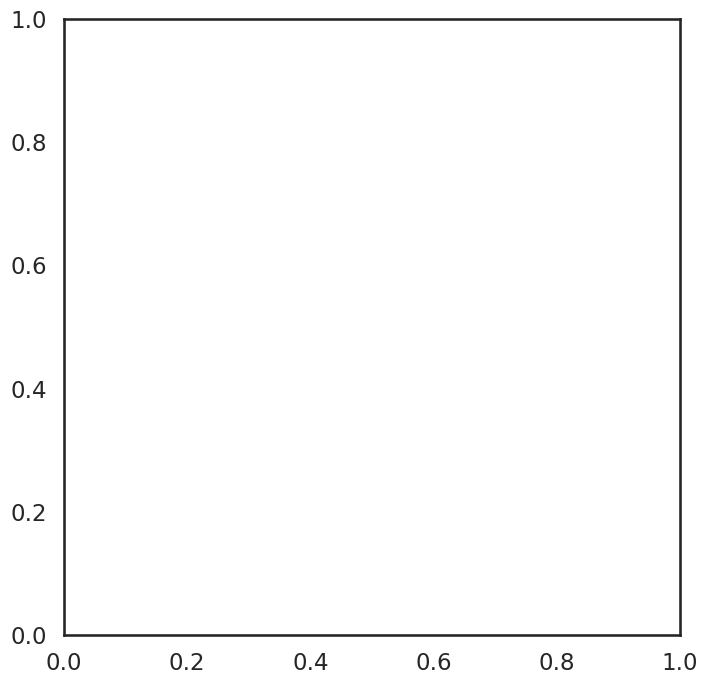

In [ ]:
from src.models import UResNet
checkpoint_path = "checkpoints/SegmentationTrainer_epoch_1.pth"
model = vis.load_model_checkpoint(checkpoint_path, UResNet, config)
vis.visualise_event(dataset, event_index=0, model=model)